# Imports and modules

In [66]:
import os
import requests
import pandas as pd
import time 
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Extract data from CSV

## Function to extract data from CSV

In [67]:
def get_data(path, file_names):
    tables=[]
    for file_name in file_names:
        table = pd.read_csv(f'../{path}/{file_name}.csv')
        table['type']=f'{file_name}'
        tables.append(table)
    return pd.concat(tables)

path='data/raw_data'
file_names = ['trawlers', 'drifting_longlines', 'fixed_gear', 'pole_and_line', 'purse_seines', 'trollers', 'unknown']

df = get_data(path, file_names)

df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,type
0,1.252340e+12,1.325376e+09,0.0,0.0,0.0,153.0,52.458649,4.581200,-1.0,gfw,trawlers
1,1.252340e+12,1.325378e+09,0.0,0.0,0.0,153.0,52.458668,4.581167,-1.0,gfw,trawlers
2,1.252340e+12,1.325379e+09,0.0,0.0,0.0,153.0,52.458633,4.581183,-1.0,gfw,trawlers
3,1.252340e+12,1.325380e+09,0.0,0.0,0.0,153.0,52.458649,4.581234,-1.0,gfw,trawlers
4,1.252340e+12,1.325381e+09,0.0,0.0,0.0,153.0,52.458649,4.581183,-1.0,gfw,trawlers


In [68]:
df['mmsi'].nunique()

354

## Remove unknown (-1 in is_fishing column)

In [69]:
df = df.loc[df['is_fishing'] > -1]

In [70]:
df['is_fishing'].value_counts()

is_fishing
0.000000    295979
1.000000    247498
0.666667      4806
0.333333      4096
0.750000       752
0.250000       670
0.800000        33
0.166667        12
0.400000         9
Name: count, dtype: int64

## OHE 'type'

In [71]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output =False)

# Fit encoder
ohe.fit(df[['type']])

# Transform the current "Alley" column
df[ohe.get_feature_names_out()] = ohe.transform(df[['type']])

# Drop the column "Alley" which has been encoded
df.drop(columns = ["type", "source"], inplace = True)

## Converting is_fishing to Binary (0 or 1)

In [72]:
df_fishing = df
df_fishing['is_fishing'].value_counts()

is_fishing
0.000000    295979
1.000000    247498
0.666667      4806
0.333333      4096
0.750000       752
0.250000       670
0.800000        33
0.166667        12
0.400000         9
Name: count, dtype: int64

In [73]:
# round the decimals so that number becomes 0 or 1
df_fishing.loc[:, ('is_fishing')] = round(df_fishing.loc[:, ('is_fishing')])

In [74]:
# check the unique values
df_fishing['is_fishing'].value_counts()

is_fishing
0.0    300766
1.0    253089
Name: count, dtype: int64

In [75]:
df_fishing.head(3)

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown
60646,1.252340e+12,1.420089e+09,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60647,1.252340e+12,1.420090e+09,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60648,1.252340e+12,1.420090e+09,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Date Engineering

## Converting timestamp to datetime format

In [76]:
df_fishing['timestamp'] = pd.to_datetime(df_fishing['timestamp'], unit='s')
df_fishing.head(2)

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [77]:
df_fishing.rename(columns={"timestamp": "date"}, inplace=True)
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [78]:
df_fishing['year'] = df_fishing['date'].dt.year
# 12 columns for month
df_fishing['month'] = df_fishing['date'].dt.month
#df_fishing['day'] = df_fishing['date'].dt.day
# 7 columns for days
df_fishing['day_of_week'] = df_fishing['date'].dt.day_of_week
#df_fishing['day_of_year'] = df_fishing['date'].dt.day_of_year
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3


## Using Angular distance for the days of the week

In [79]:
df_fishing['day_of_week_sin'] = np.sin(df_fishing['day_of_week'] * (2 * np.pi / 7))
df_fishing['day_of_week_cos'] = np.cos(df_fishing['day_of_week'] * (2 * np.pi / 7))
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,...,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week,day_of_week_sin,day_of_week_cos
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969


## UTC converter

In [80]:
import pytz
from datetime import datetime

def get_utc_offset_from_longitude(longitude):
    timezone = pytz.timezone(pytz.country_timezones("US")[0])  # You can replace "US" with the appropriate country code
    now = datetime.now(timezone)
    utc_offset = now.utcoffset().total_seconds() / 3600
    return utc_offset

df_fishing['utc_offset'] = df_fishing['lon'].apply(get_utc_offset_from_longitude)
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,...,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week,day_of_week_sin,day_of_week_cos,utc_offset
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,...,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969,-4.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,...,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969,-4.0
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,...,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969,-4.0
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,...,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969,-4.0
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,...,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969,-4.0


## Encoding dates

In [81]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output =False)

# Fit encoder
ohe.fit(df_fishing[['day_of_week']])

# Transform the current "Alley" column
df_fishing[ohe.get_feature_names_out()] = ohe.transform(df_fishing[['day_of_week']])

# Drop the column "Alley" which has been encoded
df_fishing.drop(columns = ["day_of_week"], inplace = True)

In [82]:
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,...,day_of_week_sin,day_of_week_cos,utc_offset,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [83]:
df_fishing.isna().sum()

mmsi                       0
date                       0
distance_from_shore        0
distance_from_port         0
speed                      2
course                     2
lat                        0
lon                        0
is_fishing                 0
type_drifting_longlines    0
type_fixed_gear            0
type_pole_and_line         0
type_purse_seines          0
type_trawlers              0
type_trollers              0
type_unknown               0
year                       0
month                      0
day_of_week_sin            0
day_of_week_cos            0
utc_offset                 0
day_of_week_0              0
day_of_week_1              0
day_of_week_2              0
day_of_week_3              0
day_of_week_4              0
day_of_week_5              0
day_of_week_6              0
dtype: int64

In [84]:
# Calculate the value counts of 'mmsi'
mmsi_counts = df_fishing['mmsi'].value_counts()

# Create a boolean mask for filtering mmsi values with counts less than or equal to 20
mask = mmsi_counts > 20

# Get the mmsi values that meet the condition
selected_mmsi = mmsi_counts[mask].index

# Use the isin() method to filter the DataFrame based on selected_mmsi
filtered_fishing_df = df_fishing[df_fishing['mmsi'].isin(selected_mmsi)]
filtered_fishing_df.nunique()

mmsi                          276
date                       545599
distance_from_shore         79297
distance_from_port          95687
speed                         240
course                       3602
lat                        363029
lon                        372401
is_fishing                      2
type_drifting_longlines         2
type_fixed_gear                 2
type_pole_and_line              2
type_purse_seines               2
type_trawlers                   2
type_trollers                   2
type_unknown                    2
year                            5
month                          12
day_of_week_sin                 7
day_of_week_cos                 7
utc_offset                      1
day_of_week_0                   2
day_of_week_1                   2
day_of_week_2                   2
day_of_week_3                   2
day_of_week_4                   2
day_of_week_5                   2
day_of_week_6                   2
dtype: int64

## Defining X features and y target

In [85]:
df_fishing.isna().sum()

mmsi                       0
date                       0
distance_from_shore        0
distance_from_port         0
speed                      2
course                     2
lat                        0
lon                        0
is_fishing                 0
type_drifting_longlines    0
type_fixed_gear            0
type_pole_and_line         0
type_purse_seines          0
type_trawlers              0
type_trollers              0
type_unknown               0
year                       0
month                      0
day_of_week_sin            0
day_of_week_cos            0
utc_offset                 0
day_of_week_0              0
day_of_week_1              0
day_of_week_2              0
day_of_week_3              0
day_of_week_4              0
day_of_week_5              0
day_of_week_6              0
dtype: int64

In [86]:
# Dropping rows with NAN values
df_fishing_clean = df_fishing.dropna()

In [103]:
df_fishing_clean

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,...,day_of_week_sin,day_of_week_cos,utc_offset,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.000000,0.0,128.000000,52.458717,4.581316,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.000000,0.0,128.000000,52.458733,4.581316,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.000000,0.0,128.000000,52.458698,4.581267,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.000000,0.0,128.000000,52.458698,4.581234,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.000000,0.0,128.000000,52.458683,4.581183,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6806717,2.698965e+14,2015-12-29 14:29:51,0.0,55071.328125,0.0,0.000000,43.310925,13.734748,1.0,0.0,...,0.781831,0.623490,-4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6806718,2.698965e+14,2015-12-29 14:46:08,0.0,55071.328125,0.0,0.000000,43.310932,13.734747,1.0,0.0,...,0.781831,0.623490,-4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6806719,2.698965e+14,2015-12-29 15:02:30,0.0,55071.328125,0.0,0.000000,43.310944,13.734741,1.0,0.0,...,0.781831,0.623490,-4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6806720,2.698965e+14,2015-12-29 15:18:29,0.0,55071.328125,0.0,0.000000,43.310955,13.734722,1.0,0.0,...,0.781831,0.623490,-4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [87]:
df_fishing_clean.shape

(553853, 28)

In [88]:
# Defining X - the features and Y - the target
X = df_fishing_clean.drop(columns=['date', 'is_fishing', 'utc_offset'])
y = df_fishing_clean['is_fishing']

In [89]:
X.shape

(553853, 25)

In [90]:
y.shape

(553853,)

# Correlation

## Pearson correlation

In [91]:
from sklearn.feature_selection import r_regression
corr = r_regression(X, y)
col_names = list(X.columns)
df_corr = pd.DataFrame(corr, col_names)
df_corr

,0
mmsi,0.068431
distance_from_shore,0.351586
distance_from_port,0.382767
speed,0.180394
course,-0.017665
lat,-0.179662
lon,-0.055053
type_drifting_longlines,0.288469
type_fixed_gear,-0.108185
type_pole_and_line,-0.044696


## Heatmap

In [92]:
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

In [93]:
data = df_fishing_clean.drop(columns=['date', 'utc_offset'])

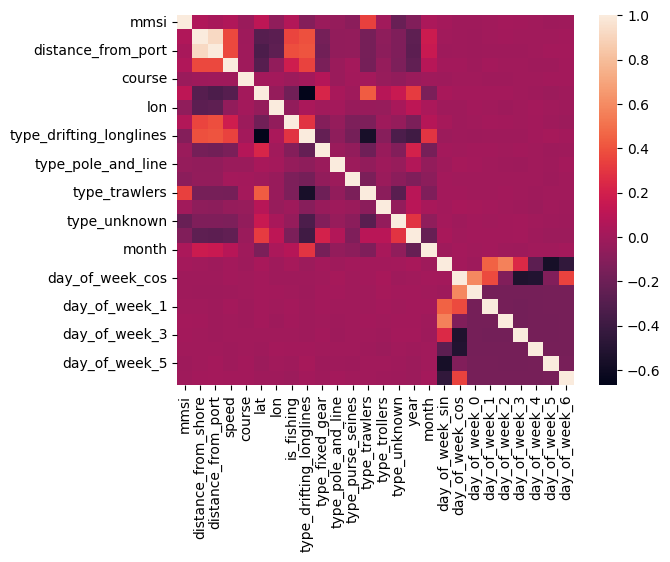

In [94]:
# plotting correlation heatmap
dataplot=sb.heatmap(data.corr())
  
# displaying heatmap
mp.show()

# Split between train set and test set

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

# Standard scaler

In [96]:
from sklearn.preprocessing import StandardScaler

# Step 0 - Instantiate and fit Standard Scaler
scaler = StandardScaler()
scaler.fit(X_train)

# Step 1 - Scale/Transform
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regresssion

In [97]:
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, learning_curve, train_test_split
from sklearn.preprocessing import PolynomialFeatures

model = LogisticRegression(max_iter=1000).fit(X,y)

# Score the model
# LogisticRegression will default scoring to accuracy.
model.score(X,y)

0.5430412040740052

In [98]:
y_pred = model.predict(X_test_scaled)

In [100]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.44      0.47     90339
         1.0       0.42      0.49      0.45     75817

    accuracy                           0.46    166156
   macro avg       0.46      0.46      0.46    166156
weighted avg       0.47      0.46      0.46    166156



## KNN Regressor

In [104]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate

# Instanciate the model
# n_neighbors=5 (default)
knn_model = KNeighborsRegressor(n_neighbors=1).fit(X_train, y_train)

# Train the model on the scaled Training data
cv_results = cross_validate(knn_model, X_train, y_train, cv=5)

base_knn_score = cv_results['test_score'].mean()

base_knn_score

-0.15452193131495445

# Export to CSV for quick access

In [ ]:
output_folder = '../data/preprocessed'
output_file = 'preproc.csv'

# Construct the full path
output_path = f'{output_folder}/{output_file}'

# Save the DataFrame to the specified path
df_fishing.to_csv(output_path, index=False)

# Map data on world map with geopandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

In [ ]:
geometry = [Point(xy) for xy in zip(df_fishing['lon'], df_fishing['lat'])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(df_fishing, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

## Mapping one boat

In [ ]:
boat = geo_df._get_value(60649, 'mmsi')
one_boat = geo_df.loc[geo_df['mmsi']== boat]

In [ ]:
# Getting world map data from geo pandas
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting Longitudes and Latitudes of one boat
x = one_boat['lon']
y = one_boat['lat']
plt.scatter(x, y, cmap='autumn')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Mapping all boats

In [ ]:
# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting Longitudes and Latitudes of one boat
x = geo_df['lon']
y = geo_df['lat']
boats = geo_df['mmsi']
plt.scatter(x, y, c=boats, cmap='autumn')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()